In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Dict, List
from datetime import datetime
from tqdm import tqdm
import pickle

In [53]:
with open('results.pkl', 'rb') as file:
    results = pickle.load(file)

# data

In [54]:
results

{'gpt-4o-mini':           prompt      harm  fairness   ingroup  authority    purity  \
 0           none  4.291667  3.750000  4.166667   3.625000  3.375000   
 1    utilitarian  3.583333  3.750000  3.875000   3.250000  3.041667   
 2         virtue  4.458333       NaN  4.250000   3.291667  3.375000   
 3  deontological  4.125000  4.666667  4.125000        NaN  3.416667   
 
        total  refusals  
 0  19.208333         4  
 1  17.500000         3  
 2        NaN        19  
 3        NaN         5  ,
 'gpt-4o': Empty DataFrame
 Columns: [prompt, harm, fairness, ingroup, authority, purity, total, refusals]
 Index: [],
 'mistral-7b-instruct':           prompt      harm  fairness   ingroup  authority    purity  \
 0           none  2.750000  4.097222  3.500000   2.958333  2.569444   
 1    utilitarian  3.041667  3.291667  3.708333   3.000000  2.291667   
 2         virtue  3.958333  4.625000  4.083333   3.166667  2.791667   
 3  deontological  3.041667  4.458333  3.708333   3.041667  2.

In [55]:
results.keys()

dict_keys(['gpt-4o-mini', 'gpt-4o', 'mistral-7b-instruct', 'mixtral-8x7b', 'claude-3-haiku', 'claude-3.5-sonnet', 'llama-3.1-8b', 'llama-3.1-70b', 'llama-3.1-405b'])

In [56]:
results_diff = {}

for model in results.keys():
    results_diff[model] = pd.DataFrame(columns=['prompt', 'harm', 'fairness', 'ingroup', 'authority', 'purity', 'total'])
    for i, row in results[model].iterrows():
        if row['prompt'] != 'none':
            row_diff = {
                'prompt': row['prompt'],
                'harm': abs(results[model].loc[results[model]['prompt'] == 'none', 'harm'].values[0] - row['harm']),
                'fairness': abs(results[model].loc[results[model]['prompt'] == 'none', 'fairness'].values[0] - row['fairness']),
                'ingroup': abs(results[model].loc[results[model]['prompt'] == 'none', 'ingroup'].values[0] - row['ingroup']),
                'authority': abs(results[model].loc[results[model]['prompt'] == 'none', 'authority'].values[0] - row['authority']),
                'purity': abs(results[model].loc[results[model]['prompt'] == 'none', 'purity'].values[0] - row['purity'])
            }
            row_diff['total'] = sum(value for key, value in row_diff.items() if key != 'prompt')
            results_diff[model] = pd.concat([results_diff[model], pd.DataFrame([row_diff])], ignore_index=True)

In [57]:
results_diff

{'gpt-4o-mini':           prompt      harm  fairness   ingroup  authority    purity     total
 0    utilitarian  0.708333  0.000000  0.291667   0.375000  0.333333  1.708333
 1         virtue  0.166667       NaN  0.083333   0.333333  0.000000       NaN
 2  deontological  0.166667  0.916667  0.041667        NaN  0.041667       NaN,
 'gpt-4o': Empty DataFrame
 Columns: [prompt, harm, fairness, ingroup, authority, purity, total]
 Index: [],
 'mistral-7b-instruct':           prompt      harm  fairness   ingroup  authority    purity     total
 0    utilitarian  0.291667  0.805556  0.208333   0.041667  0.277778  1.625000
 1         virtue  1.208333  0.527778  0.583333   0.208333  0.222222  2.750000
 2  deontological  0.291667  0.361111  0.208333   0.083333  0.097222  1.041667,
 'mixtral-8x7b':           prompt      harm  fairness   ingroup  authority    purity     total
 0    utilitarian  0.250000  0.486111  0.513889   0.375000  0.625000  2.250000
 1         virtue  0.541667  0.083333  0.1250

# viz

## bars

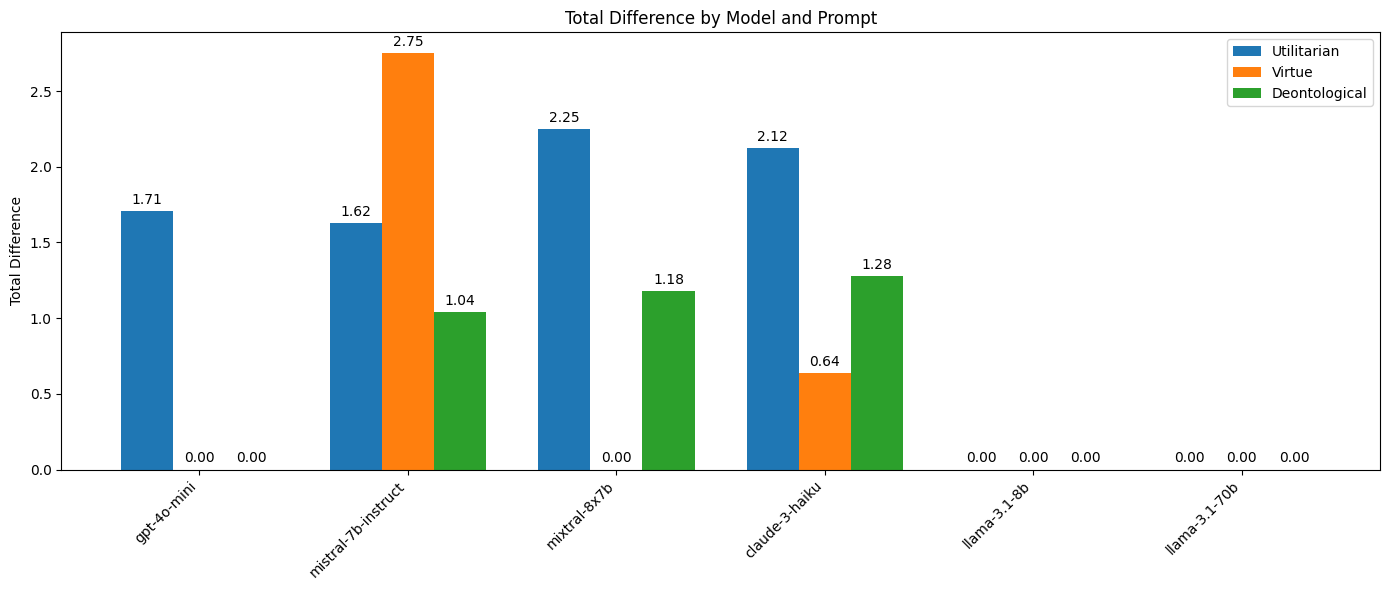

In [59]:
import matplotlib.pyplot as plt
import numpy as np

# Prepare the data
models = []
utilitarian_totals = []
virtue_totals = []
deontological_totals = []

for model, df in results_diff.items():
    if not df.empty:
        models.append(model)
        utilitarian_total = df[df['prompt'] == 'utilitarian']['total'].values[0]
        virtue_total = df[df['prompt'] == 'virtue']['total'].values[0]
        deontological_total = df[df['prompt'] == 'deontological']['total'].values[0]
        
        utilitarian_totals.append(utilitarian_total if not np.isnan(utilitarian_total) else 0)
        virtue_totals.append(virtue_total if not np.isnan(virtue_total) else 0)
        deontological_totals.append(deontological_total if not np.isnan(deontological_total) else 0)

# Set up the plot
x = np.arange(len(models))
width = 0.25

fig, ax = plt.subplots(figsize=(14, 6))

# Create the bars
rects1 = ax.bar(x - width, utilitarian_totals, width, label='Utilitarian')
rects2 = ax.bar(x, virtue_totals, width, label='Virtue')
rects3 = ax.bar(x + width, deontological_totals, width, label='Deontological')

# Customize the plot
ax.set_ylabel('Total Difference')
ax.set_title('Total Difference by Model and Prompt')
ax.set_xticks(x)
ax.set_xticklabels(models, rotation=45, ha='right')
ax.legend()

# Add value labels on top of each bar
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

plt.tight_layout()
plt.show()

## radar charts

In [33]:
def plot_radar_chart(scores_dict: Dict[str, List[float]], title: str = None, filename=None):
    # Define the attributes
    attributes = ['Care', 'Fairness', 'Loyalty', 'Authority', 'Sanctity']
    num_attrs = len(attributes)
    
    # Calculate the angle for each attribute
    angles = [n / float(num_attrs) * 2 * np.pi for n in range(num_attrs)]
    angles += angles[:1]  # Complete the circle
    
    # Create the plot
    fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(projection='polar'))
    
    # Plot each dataset
    for label, scores in scores_dict.items():
        values = scores + scores[:1]  # Complete the polygon
        ax.plot(angles, values, linewidth=2, linestyle='solid', label=label)
        ax.fill(angles, values, alpha=0.1)
    
    # Set the labels
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(attributes)
    
    # Set y-axis limits
    ax.set_ylim(0, 5)
    
    # Add legend
    plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0))
    
    plt.title(title)
    plt.tight_layout()

    if filename:
        plt.savefig(filename, format='pdf', bbox_inches='tight')

    plt.show()


In [34]:
def get_scores(model, prompt_name):
    row = results[model].loc[results[model]['prompt'] == prompt_name]
    return row[['harm', 'fairness', 'ingroup', 'authority', 'purity']].values.flatten().tolist()

In [35]:
get_scores('gpt-4o-mini', 'none')

[4.291666666666667, 3.75, 4.166666666666667, 3.625, 3.375]

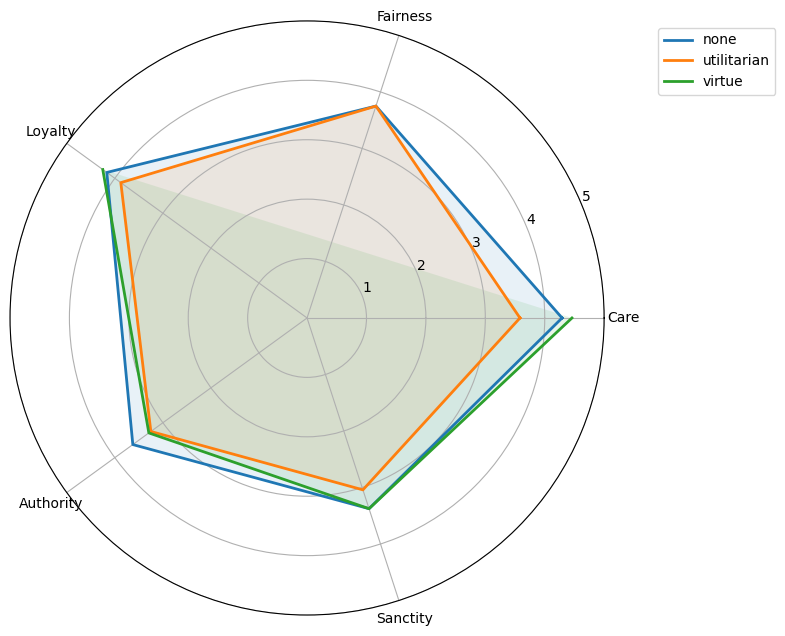

In [36]:
model = 'gpt-4o-mini'
plot_radar_chart({'none': get_scores(model, 'none'), 'utilitarian': get_scores(model, 'utilitarian'), 'virtue': get_scores(model, 'virtue')})

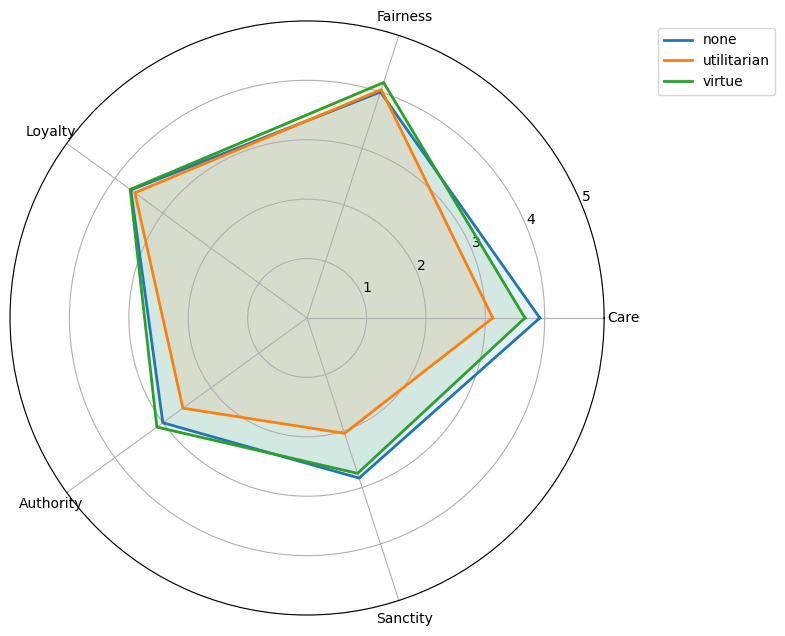

In [37]:
model = 'claude-3-haiku'
plot_radar_chart({'none': get_scores(model, 'none'), 'utilitarian': get_scores(model, 'utilitarian'), 'virtue': get_scores(model, 'virtue')})

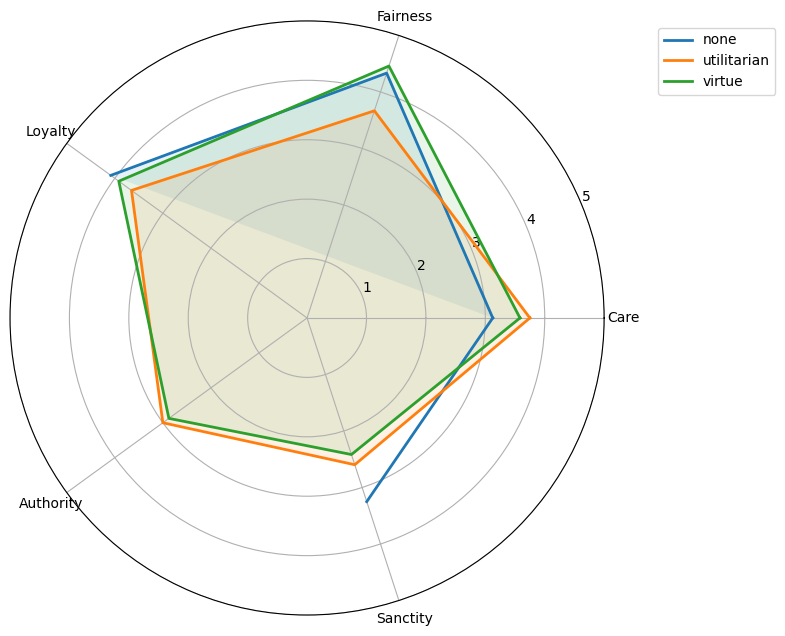

In [38]:
model = 'llama-3.1-8b'
plot_radar_chart({'none': get_scores(model, 'none'), 'utilitarian': get_scores(model, 'utilitarian'), 'virtue': get_scores(model, 'virtue')})

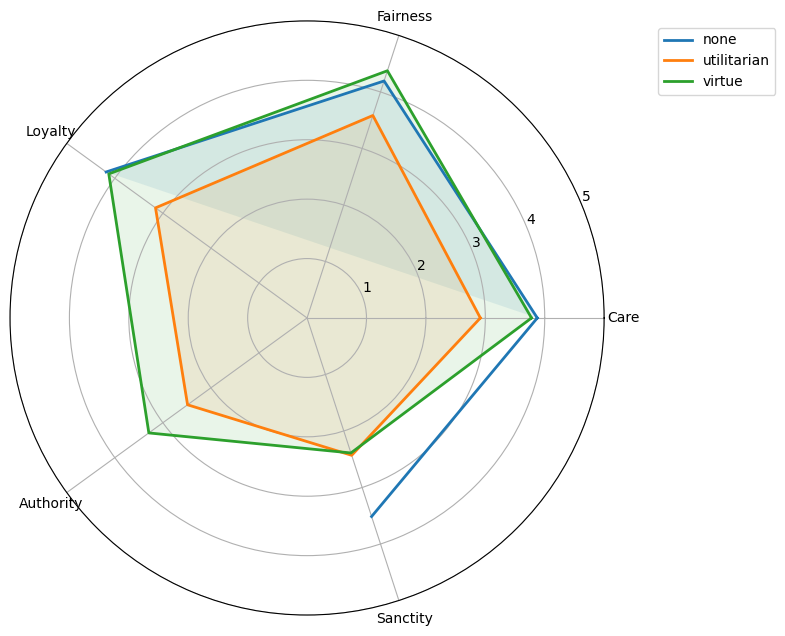

In [39]:
model = 'llama-3.1-70b'
plot_radar_chart({'none': get_scores(model, 'none'), 'utilitarian': get_scores(model, 'utilitarian'), 'virtue': get_scores(model, 'virtue')})

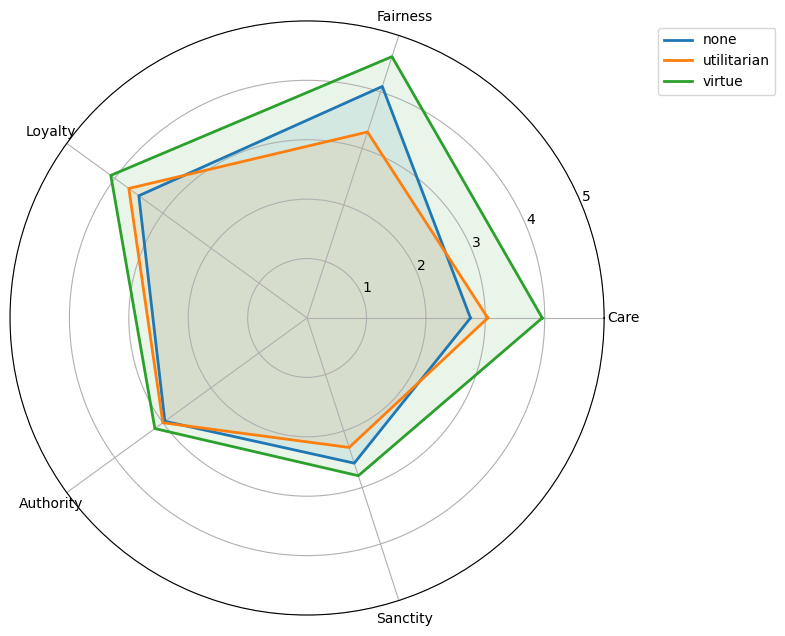

In [40]:
model = 'mistral-7b-instruct'
plot_radar_chart({'none': get_scores(model, 'none'), 'utilitarian': get_scores(model, 'utilitarian'), 'virtue': get_scores(model, 'virtue')})

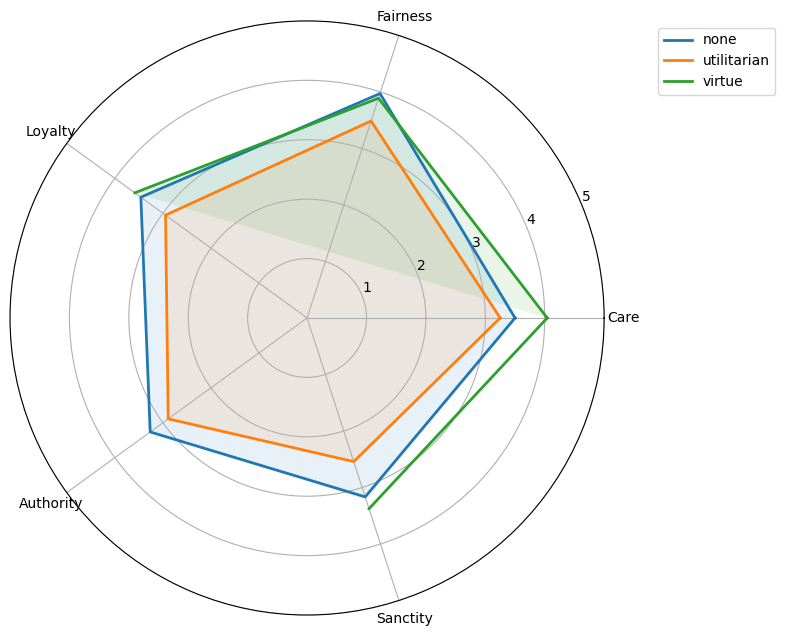

In [41]:
model = 'mixtral-8x7b'
plot_radar_chart({'none': get_scores(model, 'none'), 'utilitarian': get_scores(model, 'utilitarian'), 'virtue': get_scores(model, 'virtue')})